## Import Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle
from numpy.linalg import inv as inv

#Import function to get the covariate matrix that includes spike history from previous bins
from preprocessing_funcs import get_spikes_with_history

#Import decoder functions
import Decoder_funcs
from Decoder_funcs import get_vaf

/opt/anaconda/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.
Using gpu device 3: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)
/opt/anaconda/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


## Import Data

**Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin**

**The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"**

In [3]:
# folder='/Users/jig289/Dropbox/MATLAB/Projects/In_Progress/BMI/Processed_Data/'
folder='/home/jglaser2/Data/DecData/'

with open(folder+'test_data.pickle','rb') as f:
    neural_data,vels_binned=pickle.load(f)

## Define Covariates ##

### User Options: Define what time period to use spikes from

In [4]:
#This is relevant for all decoders except the Kalman filter (KF)

bins_current=1 #Whether to use concurrent time bin of neural data
bins_before=13 #How many bins of neural data prior to the output are used for decoding
bins_after=0 #How many bins of neural data after (and including) the output are used for decoding
bins_surrounding=bins_before+bins_before+bins_after


# Below is only relevant for the KF

lag=-2 #What time bin of spikes should be used relative to the output
#(lag=-1 means use the spikes 1 bin before the output)

### Get Input Covariates

In [42]:
#Function to get the covariate matrix that includes spike history from previous bins
#This puts the spikes in the format for the RNN
X=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

#Put in "flat" format for XGB and linear decoders
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

#Format for Kalman filter
X_kf=neural_data

### Get Output Covariates

In [43]:
#Set decoding output for all decoders except the KF
y=vels_binned


#Set decoding output for the KF
pos=np.zeros(vels_binned.shape)
pos[0,:]=0
for i in range(pos.shape[0]-1):
    pos[i+1,0]=pos[i,0]+vels_binned[i,0]*.05
    pos[i+1,1]=pos[i,1]+vels_binned[i,1]*.05
    
temp=np.diff(vels_binned,axis=0)
acc=np.concatenate((temp,temp[-1:,:]),axis=0)

y_kf=np.concatenate((pos,vels_binned,acc),axis=1)

### Process Covariates

In [44]:
def zscore_nan(X,axis):
    X_zscore=(X - np.nanmean(X,axis=axis)) / np.nanstd(X,axis=axis)
    return X_zscore

In [45]:
#Normalize inputs
X=zscore_nan(X,axis=0)
X_flat=zscore_nan(X_flat,axis=0)

#Zero-center outputs
y_mean=np.mean(y,axis=0)
y=y-y_mean

y_kf_mean=np.mean(y_kf,axis=0)
y_kf=y_kf-y_kf_mean

In [ ]:
#More Kalman filter preprocessing

#Re-align data to take lag into account
if lag<0:
    y_kf=y_kf[-lag:,:]
    X_kf=X_kf[0:num_examples+lag,:]
if lag>0:
    y_kf=y_kf[0:num_examples-lag,:]
    X_kf=X_kf[lag:num_examples,:]

## Split into training/testing/validation sets

### User Options

In [46]:
#Set what part of data should be part of the training/testing/validation sets
training_range=[0, 0.7]
testing_range=[0.7, 0.85]
valid_range=[0.85,1]

### Split Data: For all decoders except KF

In [10]:
num_examples=X.shape[0]

#Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
#This makes it so that the different sets don't include overlapping neural data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples))+bins_before,np.int(np.round(testing_range[1]*num_examples))-bins_after)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples))+bins_before,np.int(np.round(valid_range[1]*num_examples))-bins_after)

#Get training data
X_train=X[training_set,:,:]
X_flat_train=X_flat[training_set,:]
y_train=y[training_set,:]

#Get testing data
X_test=X[testing_set,:,:]
X_flat_test=X_flat[testing_set,:]
y_test=y[testing_set,:]

#Get validation data
X_valid=X[valid_set,:,:]
X_flat_valid=X_flat[valid_set,:]
y_valid=y[valid_set,:]

### Split Data: For KF

In [47]:
#Number of examples after taking into account bins removed for lag alignment
num_examples_kf=X_kf.shape[0]
        
#Note that each range has a buffer of 1 bin at the beginning and end
#This makes it so that the different sets don't include overlapping data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples_kf))+1,np.int(np.round(training_range[1]*num_examples_kf))-1)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples_kf))+1,np.int(np.round(testing_range[1]*num_examples_kf))-1)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples_kf))+1,np.int(np.round(valid_range[1]*num_examples_kf))-1)

#Get training data
X_kf_train=X_kf[training_set,:]
y_kf_train=y_kf[training_set,:]

#Get testing data
X_kf_test=X_kf[testing_set,:]
y_kf_test=y_kf[testing_set,:]

#Get validation data
X_kf_valid=X_kf[valid_set,:]
y_kf_valid=y_kf[valid_set,:]

## Run Decoders

### Wiener Filter (Linear Regression)

In [11]:
#Fit model
model_regr=Decoder_funcs.lin_reg_model(X_flat_train,y_train)
#Get predictions
y_valid_pred_lin=model_regr.predict(X_flat_valid)
#Get metric of fit
vafs_lin=get_vaf(y_valid,y_valid_pred_lin)
print('VAFS:', vafs_lin)

[0.75176754708627835, 0.75100935332779462]


### Wiener Cascade (Linear Nonlinear Model)

In [62]:
#Fit model
models_wc=Decoder_funcs.wiener_casc_model(X_flat_train,y_train,deg=3)
#Get predictions
y_valid_pred_wc=Decoder_funcs.wiener_casc_predict(models_wc,X_flat_valid)
#Get metric of fit
vafs_wc=get_vaf(y_valid,y_valid_pred_wc)
print('VAFS:', vafs_wc)

AttributeError: 'module' object has no attribute 'wiener_casc_model'

### XGBoost (Extreme Gradient Boosting)

In [12]:
#Fit model
model_xgb=Decoder_funcs.xgb_model(X_flat_train,y_train,max_depth=3,num_round=200)
#Get predictions
y_valid_pred_xgb=Decoder_funcs.xgb_predict(model_xgb,X_flat_valid)
#Get metric of fit
vafs_xgb=get_vaf(y_valid,y_valid_pred_xgb)
print('VAFS:', vafs_xgb)

[0.78257987600003387, 0.77279201623015137]


### Simple RNN

In [17]:
#Fit model
model_rnn=Decoder_funcs.SimpleRNN_model(X_train,y_train,units=400,dropout=0,num_epochs=10)
#Get predictions
y_valid_pred_rnn=model_rnn.predict(X_valid)
#Get metric of fit
vafs_rnn=get_vaf(y_valid,y_valid_pred_rnn)
print('VAFS:', vafs_rnn)

[0.8179415562127349, 0.78331080265241537]


### GRU (Gated Recurrent Unit)

In [14]:
#Fit model
model_gru=Decoder_funcs.GRU_model(X_train,y_train,units=400,dropout=0,num_epochs=10)
#Get predictions
y_valid_pred_gru=model_gru.predict(X_valid)
#Get metric of fit
vafs_gru=get_vaf(y_valid,y_valid_pred_gru)
print('VAFS:', vafs_gru)

('VAFS:', [0.87255717267620037, 0.83728626003289441])


### LSTM (Long Short Term Memory)

In [16]:
#Fit model
model_lstm=Decoder_funcs.LSTM_model(X_train,y_train,units=400,dropout=0,num_epochs=10)
#Get predictions
y_valid_pred_lstm=model_lstm.predict(X_valid)
#Get metric of fit
vafs_lstm=get_vaf(y_valid,y_valid_pred_lstm)
print('VAFS:', vafs_lstm)

('VAFS:', [0.88011000858631538, 0.84203013604606314])


### Kalman Filter

In [61]:
#Fit model
model_kf=Decoder_funcs.kf_model(X_kf_train,y_kf_train)
#Get predictions
y_valid_pred_kf=Decoder_funcs.kf_predict(model_kf,X_kf_valid,y_kf_valid)
#Get metric of fit
vafs_kf=get_vaf(y_kf_valid,y_pred_kf)
print('VAFS:',vafs_kf[2:4])

('VAFS:', [0.72451170463328052, 0.71332358177716682])


## Make Plots

In [ ]:
#As an example, I plot the first 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
fig_x_lin=plt.figure()
plt.plot(y_test[0:1000,0],'b')
plt.plot(y_test_pred_lin[0:1000,0],'r')
#Save figure
# fig_x_lin.savefig('x_velocity_decoding.eps')

In [21]:
from sklearn import linear_model

In [93]:
def wiener_casc(X_flat_train,y_train,X_flat_test,y_test,deg=3):
    num_outputs=y_train.shape[1]
    y_test_pred_ln=np.empty(y_test.shape)
    for i in range(num_outputs):
        regr = linear_model.LinearRegression()
        regr.fit(X_flat_train, y_train[:,i]) #Fit linear
        y_train_pred_lin=regr.predict(X_flat_train) 
        p=np.polyfit(y_train_pred_lin,y_train[:,i],deg) #Fit nonlinear
        y_train_pred_ln=np.polyval(p,y_train_pred_lin)
        #Predictions on test set
        y_test_pred_lin=regr.predict(X_flat_test)
        y_test_pred_ln[:,i]=np.polyval(p,y_test_pred_lin)
    return y_test_pred_ln

In [ ]:
y_valid_pred_wc=wiener_casc(X_flat_train,y_train,X_flat_valid,y_valid,deg=3)

In [18]:
def wiener_casc_model(X_flat_train,y_train,deg=3):
    num_outputs=y_train.shape[1]
    models=[]
    for i in range(num_outputs):
        regr = linear_model.LinearRegression()
        regr.fit(X_flat_train, y_train[:,i]) #Fit linear
        y_train_pred_lin=regr.predict(X_flat_train) 
        p=np.polyfit(y_train_pred_lin,y_train[:,i],deg) #Fit nonlinear
        models.append([regr,p])
    return models

In [19]:
def wiener_casc_predict(models,X_flat_test):
    num_outputs=len(models)
    y_test_pred_ln=np.empty([X_flat_test.shape[0],num_outputs])
    for i in range(num_outputs):
        [regr,p]=models[i]
        #Predictions on test set
        y_test_pred_lin=regr.predict(X_flat_test)
        y_test_pred_ln[:,i]=np.polyval(p,y_test_pred_lin)
    return y_test_pred_ln    

In [22]:
models_wc=wiener_casc_model(X_flat_train,y_train,deg=3)

In [23]:
y_valid_pred_wc=wiener_casc_pred(models_wc,X_flat_valid)

In [24]:
vafs_wc=get_vaf(y_valid,y_valid_pred_wc)
vafs_wc

[0.75846086040360672, 0.76774970824995881]

In [54]:
def kf_model(zs,xs):
    #xs are the state (here, the variable we're predicting)
    #zs are the observed variable (neural data here)
    
    
    #Reformat matrices
    X=np.matrix(xs.T)
    Z=np.matrix(zs.T)
        
    #number of time bins (after reformatting for the lag)
    nt=X.shape[1]
    
    # Compute the variables required for filtering, according to Wu et al
    X2 = X[:,1:]
    X1 = X[:,0:nt-1]
    # The least-squares-optimal transformation from x_i to x_(i+1)
    A=X2*X1.T*inv(X1*X1.T)
    W=(X2-A*X1)*(X2-A*X1).T/(nt-1)

    # The least-squares-optimal transformation from x_i to z_i
    # (the transformation from position to spikes)
    H = Z*X.T*(inv(X*X.T))
    Q = ((Z - H*X)*((Z - H*X).T)) / nt
    params=[A,W,H,Q]
    return params

In [28]:
# def kf_predict(zs,xs,lag,params):
#     #xs are the state (here, the variable we're predicting)
#     #zs are the observed variable (neural data here)
    
#     #number of time bins, originally
#     nt_orig=xs.shape[0]
    
#     if lag<0:
#         xs=xs[-lag:,:]
#         zs=zs[0:nt_orig+lag,:]
    
#     if lag>0:
#         xs=xs[0:nt_orig-lag,:]
#         zs=zs[lag:nt_orig,:]
    
#     #Reformat matrices
#     X=np.matrix(xs.T)
#     Z=np.matrix(zs.T)
    
#     #Extract parameters
#     A,W,H,Q=params
    
#     #Initialize
#     num_states=X.shape[0]
#     states=np.empty(X.shape)
#     P_m=np.matrix(np.zeros([num_states,num_states]))
#     P=np.matrix(np.zeros([num_states,num_states]))
#     state=X[:,0]
#     states[:,0]=np.copy(np.squeeze(state))

#     for t in range(X.shape[1]-1):
# #         P_m=np.copy(A*P*A.T+W)
# #         state_m=np.copy(A*state)

#         P_m=A*P*A.T+W
#         state_m=A*state
        
#         K=P_m*H.T*inv(H*P_m*H.T+Q)
#         P=(np.matrix(np.eye(num_states))-K*H)*P_m
#         state=state_m+K*(Z[:,t+1]-H*state_m)
# #         states[:,t+1]=np.copy(np.squeeze(state))
#         states[:,t+1]=np.squeeze(state)
#     return states.T

In [55]:
def kf_predict(params,zs,xs):
    #xs are the state (here, the variable we're predicting)
    #zs are the observed variable (neural data here)
    
    #Extract parameters
    A,W,H,Q=params
    
    #Reformat matrices
    X=np.matrix(xs.T)
    Z=np.matrix(zs.T)
    
    
    #Initialize
    num_states=X.shape[0]
    states=np.empty(X.shape)
    P_m=np.matrix(np.zeros([num_states,num_states]))
    P=np.matrix(np.zeros([num_states,num_states]))
    state=X[:,0]
    states[:,0]=np.copy(np.squeeze(state))

    for t in range(X.shape[1]-1):
#         P_m=np.copy(A*P*A.T+W)
#         state_m=np.copy(A*state)

        P_m=A*P*A.T+W
        state_m=A*state
        
        K=P_m*H.T*inv(H*P_m*H.T+Q)
        P=(np.matrix(np.eye(num_states))-K*H)*P_m
        state=state_m+K*(Z[:,t+1]-H*state_m)
#         states[:,t+1]=np.copy(np.squeeze(state))
        states[:,t+1]=np.squeeze(state)
    return states.T

In [57]:
model_kf=kf_model(X_kf_train,y_kf_train)

In [58]:
y_pred_kf=kf_predict(model_kf,X_kf_valid,y_kf_valid)

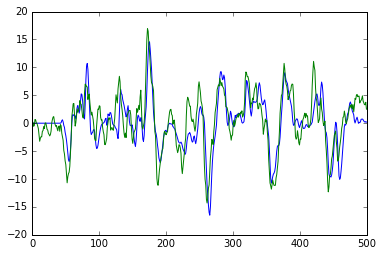

In [38]:
plt.plot(y_kf_valid[500:1000,2])
plt.plot(y_pred_kf[500:1000,2])


In [59]:
vafs_kf=get_vaf(y_kf_valid,y_pred_kf)
vafs_kf

[0.67699529732005903,
 0.66568885613627105,
 0.72451170463328052,
 0.71332358177716682,
 0.41133119907340709,
 0.22782605017146251]